In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from architectures import *
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from utils import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 37
ROOT_PATH = os.getcwd()
os.makedirs(DATASET_PATH := os.path.join(ROOT_PATH, "dataset"), exist_ok=True)
os.makedirs(MODELS_PATH := os.path.join(ROOT_PATH, "models"), exist_ok=True)

print(DEVICE)
seed_functions(SEED)

cuda


Loading

In [3]:
BATCH_SIZE = 32
TRAIN_RATIO = 0.8
DEV_RATIO = 0.1
TEST_RATIO = 0.1

dataset_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = datasets.ImageFolder(DATASET_PATH, transform=dataset_transform)

def split_data(dataset):
	labels = [tp[1] for tp in dataset]
	train_set, temp_set = train_test_split(dataset, test_size=(1 - TRAIN_RATIO), random_state=SEED, stratify=labels)
	temp_labels = [tp[1] for tp in temp_set]
	test_set, dev_set = train_test_split(temp_set, test_size=(TEST_RATIO / (DEV_RATIO + TEST_RATIO)), random_state=SEED, stratify=temp_labels)
	return train_set, dev_set, test_set

train_set, dev_set, test_set = split_data(dataset)

train_generator = torch.Generator().manual_seed(SEED)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
dev_loader = torch.utils.data.DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Training

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7

def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Dev Loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))

		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

model = ResNet50().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# train_model(model, train_loader, dev_loader, criterion, optimizer)

c:\Users\gregory\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gregory\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\gregory/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.7MB/s]


Epoch 1/50 - Train Loss: 0.4898 - Dev Loss: 0.5671
Epoch 2/50 - Train Loss: 0.4136 - Dev Loss: 2.1134
Epoch 3/50 - Train Loss: 0.3885 - Dev Loss: 0.3735
Epoch 4/50 - Train Loss: 0.3896 - Dev Loss: 1.6699
Epoch 5/50 - Train Loss: 0.3781 - Dev Loss: 0.4123
Epoch 6/50 - Train Loss: 0.3499 - Dev Loss: 0.3882
Epoch 7/50 - Train Loss: 0.3410 - Dev Loss: 0.3846
Epoch 8/50 - Train Loss: 0.3230 - Dev Loss: 1.7773
Epoch 9/50 - Train Loss: 0.3121 - Dev Loss: 0.8409
Epoch 10/50 - Train Loss: 0.2952 - Dev Loss: 0.4832
Stopping early


Post-training

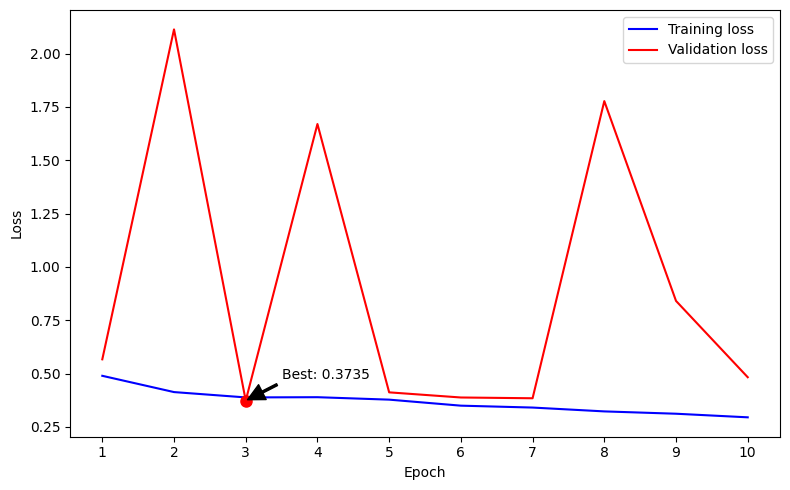

Confusion Matrix:
[[ 10  33]
 [  0 158]]


In [ ]:
def visualise_training(model):
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	with open(os.path.join(model_folder, "losses.json"), "r") as f:
		loss_data = json.load(f)
	train_losses = loss_data["train_losses"]
	dev_losses = loss_data["dev_losses"]
	plt.figure(figsize=(8, 5))
	epochs = range(1, len(train_losses) + 1)
	plt.plot(epochs, train_losses, 'b-', label='Training loss')
	plt.plot(epochs, dev_losses, 'r-', label='Validation loss')
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	best_epoch = np.argmin(dev_losses) + 1
	best_loss = min(dev_losses)
	plt.plot(best_epoch, best_loss, 'ro', markersize=8)
	plt.annotate(
		f'Best: {best_loss:.4f}',
		xy=(best_epoch, best_loss),
		xytext=(best_epoch + 0.5, best_loss + 0.1),
		arrowprops=dict(facecolor='black', shrink=0.05, width=1.5)
	)
	plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
	plt.tight_layout()
	plt.show()

from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_loader):
	model.eval()
	Y_hat, Y = [], []
	with torch.no_grad():
		for x, y in test_loader:
			logits = model(x.to(DEVICE))
			preds = torch.argmax(logits, dim=1).cpu()
			Y_hat.append(preds)
			Y.append(y.view(-1))
	y_true = torch.cat(Y).numpy()
	y_pred = torch.cat(Y_hat).numpy()
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
	f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0
	return {"tp": tp, "tn": tn, "fp": fp, "fn": fn, "f1": f1}

m = ResNet50().to(DEVICE)
visualise_training(m)

m.load_state_dict(torch.load(os.path.join(MODELS_PATH, m.id, "best.pth")))
evaluate_model(m, test_loader)